# Final Project : Facial Feature Localization

### CSC 215-01 Artificial Intelligence (Fall 2019)

### Team member : 
    1) Ayushi Vadwala
    2) Jeet Shah

### Problem Formulation :   
    The aim of the project is to find the facial features on the gray scale images given as input. The output of the model will be the predicted value of the facial coordinates in (x, y) format which will help in placing the facial filter on the image.
            
### Model used to predict Facial Feature Locations : 
- Transfer Learning (VGGFace2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
df_train = pd.read_csv('data/training.csv')

In [61]:
df_train.shape

(7049, 31)

#### Detecting OUTLIERS in Dataset
- The statistics about the key point from below BAR graph suggests that this dataset, only 2140 images are "high quality" with all keypoints, while 4909 other images are "low quality" with only 4 keypoints labelled which are the outliers.

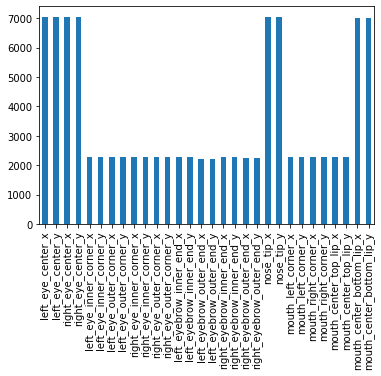

In [62]:
df_train.describe().loc['count'].plot.bar()

In [63]:
df_train = df_train.dropna() 

In [64]:
df_train.shape

(2140, 31)

#### After removing outliers every images have all 30 keypoints.

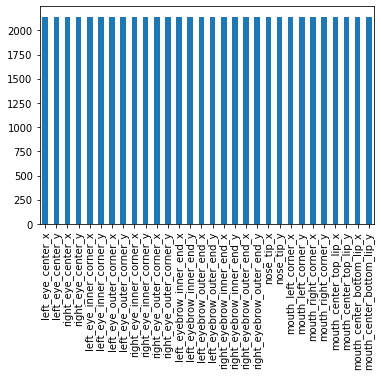

In [65]:
df_train.describe().loc['count'].plot.bar()

#### Splitting Train dataset into input and target variables.

In [9]:
image_list=[]

for i in df_train['Image']:
    i=i.split(' ')
    image_list.append(i)
len(image_list)

2140

In [10]:
#convert to array
image_list = np.array(object=image_list,dtype=float)

In [11]:
images = image_list.reshape(-1,96,96,1)

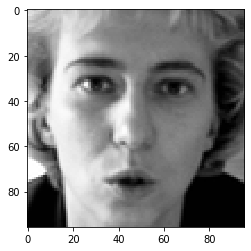

In [12]:
plt.imshow(image_list.reshape(-1,96,96)[1],cmap='gray')

In [13]:
y = df_train.drop(labels='Image',axis=1)
y.shape

(2140, 30)

In [14]:
x = images
x.shape

(2140, 96, 96, 1)

In [16]:
x = np.asarray(x)
y = np.asarray(y)

#### Spliting training dataset into train and test using sklearn's train_test_split method.

In [17]:
from sklearn.model_selection import train_test_split

global random_seed
random_seed = 9
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_seed)

In [18]:
X_train.shape

(1712, 96, 96, 1)

In [19]:
y_train.shape

(1712, 30)

In [20]:
X_test.shape

(428, 96, 96, 1)

In [21]:
y_test.shape

(428, 30)

# Transfer learning

In [22]:
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of y_train: {}".format(y_train.shape))

Shape of X_train: (1712, 96, 96, 1)
Shape of y_train: (1712, 30)


### Installation of VGGFACE2

In [23]:
#pip install git+https://github.com/rcmalli/keras-vggface.git

In [24]:
#pip install mtcnn

In [25]:
#pip install scikit-image

In [26]:
pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: c:\users\vadwalaa\.conda\envs\newenv\lib\site-packages
Requires: scipy, numpy, keras, pillow, six, h5py, pyyaml
Required-by: 
Note: you may need to restart the kernel to use updated packages.


### This shows what are the input and output shape for VGGFACE.

In [27]:
# example of creating a face embedding
from keras_vggface.vggface import VGGFace
# create a vggface2 model
model = VGGFace(model='resnet50')
# summarize input and output shape
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

Using TensorFlow backend.


Inputs: [<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>]
Outputs: [<tf.Tensor 'classifier/Softmax:0' shape=(None, 8631) dtype=float32>]


#### VGGFACE works on color images so we need to convert grey to RGB.

In [28]:
X_train_Reshape = X_train.reshape(-1,96,96)

In [29]:
X_test_Reshape = X_test.reshape(-1,96,96)

In [30]:
new_x_train = []

for image in X_train_Reshape:
    newImage = np.stack((image, image, image), axis=-1)
    new_x_train.append(newImage)

new_x_train= np.asarray(new_x_train)


In [31]:
new_x_test = []

for image in X_test_Reshape:
    newImage = np.stack((image, image, image), axis=-1)
    new_x_test.append(newImage)

new_x_test= np.asarray(new_x_test)


#### Now we have images with 3 channels.

(1712, 96, 96, 3)


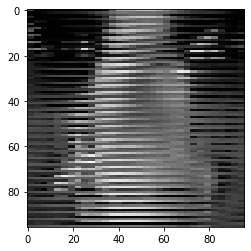

In [32]:
print(new_x_train.shape)
plt.imshow(new_x_train.reshape(-1,96,96)[1],cmap='gray')

### Upsampling

#### VGGFACE supports down to 224x224 images as input. However our training dataset images are too low in terms of resolutions (96, 96) so we need to do upsampling

#### We use resize(), provided by scikit-image to convert the resolution size of the image.

In [34]:
import skimage.transform

new_x_train_224x224 = []

for image in new_x_train:
    newImage = skimage.transform.resize(image, (224, 224)) # resize also normalizes your image
    new_x_train_224x224.append(newImage)


In [35]:
import skimage.transform

new_x_test_224x224 = []

for image in new_x_test:
    newImage = skimage.transform.resize(image, (224, 224)) # resize also normalizes your image
    new_x_test_224x224.append(newImage)


In [37]:
new_x_train_224x224 = np.asarray(new_x_train_224x224)
print("Shape of new_x_train_224x224: {}".format(new_x_train_224x224.shape))

Shape of new_x_train_224x224: (1712, 224, 224, 3)


In [38]:
new_x_test_224x224 = np.asarray(new_x_test_224x224)
print("Shape of new_x_test_224x224: {}".format(new_x_test_224x224.shape))

Shape of new_x_test_224x224: (428, 224, 224, 3)


#### Build model VGGFACE.

In [66]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from keras_vggface.vggface import VGGFace

input_shape=(224, 224, 3)
vgg_model2 = VGGFace(model='resnet50', include_top=False, input_shape=input_shape)

#### All layers of the pre-trained model need not to be trained again.

In [67]:
for layer in vgg_model2.layers:
    layer.trainable = False

#### We have removed the last 3 layers of the pre-trained model using pop().

#### Add more dense and dropout layers to the pre-trained model.

In [68]:
from keras.models import Model

vgg_model2.layers.pop()
vgg_model2.layers.pop()
vgg_model2.layers.pop()
x = vgg_model2.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024)(x)
x = Dense(30)(x)
modelTL = Model(inputs = vgg_model2.input, outputs = x)     

modelTL.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_4[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_148 (Activation)     (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [69]:
modelTL.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

In [70]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')

hist = modelTL.fit(new_x_train_224x224, y_train, batch_size=128, epochs=125, validation_data=(new_x_test_224x224, y_test),verbose=2)
hist

Train on 1712 samples, validate on 428 samples
Epoch 1/125
 - 292s - loss: 538.4073 - acc: 0.3662 - val_loss: 133.1554 - val_acc: 0.3995
Epoch 2/125
 - 351s - loss: 115.6255 - acc: 0.3843 - val_loss: 84.9807 - val_acc: 0.6939
Epoch 3/125
 - 352s - loss: 61.0050 - acc: 0.4947 - val_loss: 130.8968 - val_acc: 0.7009
Epoch 4/125
 - 355s - loss: 47.4423 - acc: 0.6180 - val_loss: 84.9713 - val_acc: 0.7196
Epoch 5/125
 - 355s - loss: 39.4562 - acc: 0.6314 - val_loss: 72.1439 - val_acc: 0.7290
Epoch 6/125
 - 357s - loss: 35.8498 - acc: 0.6554 - val_loss: 60.3389 - val_acc: 0.7266
Epoch 7/125
 - 358s - loss: 33.4418 - acc: 0.6711 - val_loss: 54.3773 - val_acc: 0.7290
Epoch 8/125
 - 352s - loss: 30.9463 - acc: 0.6729 - val_loss: 55.8969 - val_acc: 0.7593
Epoch 9/125
 - 348s - loss: 29.0279 - acc: 0.6893 - val_loss: 53.5238 - val_acc: 0.7547
Epoch 10/125
 - 347s - loss: 29.0613 - acc: 0.7161 - val_loss: 55.2633 - val_acc: 0.7009
Epoch 11/125
 - 356s - loss: 27.7141 - acc: 0.7004 - val_loss: 53.31

Epoch 93/125
 - 289s - loss: 24.2504 - acc: 0.7336 - val_loss: 42.2285 - val_acc: 0.7290
Epoch 94/125
 - 288s - loss: 24.1402 - acc: 0.7220 - val_loss: 44.5028 - val_acc: 0.7313
Epoch 95/125
 - 291s - loss: 25.3656 - acc: 0.7237 - val_loss: 40.5362 - val_acc: 0.7407
Epoch 96/125
 - 290s - loss: 25.8590 - acc: 0.7155 - val_loss: 35.9387 - val_acc: 0.7430
Epoch 97/125
 - 289s - loss: 25.1546 - acc: 0.7296 - val_loss: 43.3781 - val_acc: 0.7383
Epoch 98/125
 - 294s - loss: 24.8476 - acc: 0.7144 - val_loss: 40.8198 - val_acc: 0.7360
Epoch 99/125
 - 289s - loss: 25.5863 - acc: 0.7079 - val_loss: 53.9955 - val_acc: 0.7430
Epoch 100/125
 - 290s - loss: 24.8715 - acc: 0.7231 - val_loss: 46.4647 - val_acc: 0.7266
Epoch 101/125
 - 289s - loss: 26.0650 - acc: 0.7237 - val_loss: 44.5722 - val_acc: 0.7313
Epoch 102/125
 - 290s - loss: 24.7155 - acc: 0.7389 - val_loss: 37.5815 - val_acc: 0.7033
Epoch 103/125
 - 288s - loss: 25.4035 - acc: 0.7261 - val_loss: 55.1404 - val_acc: 0.7103
Epoch 104/125
 - 

#### RMSE and R2 Score

In [71]:
from sklearn import metrics

y_pred_TL =modelTL.predict(new_x_test_224x224)

score = np.sqrt(metrics.mean_squared_error(y_test,y_pred_TL)) 

print("Score (RMSE) : {}".format(score))
print("R2 score     :",metrics.r2_score(y_test,y_pred_TL))

Score (RMSE) : 6.635329961646067
R2 score     : -3.8463559290083684


In [72]:
y_pred_TL = np.asarray(y_pred_TL)
y_test = np.asarray(y_test)

In [73]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

#### Regression Chart

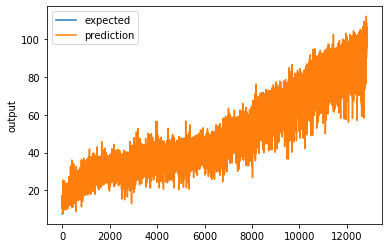

In [74]:
chart_regression(y_pred_TL.flatten(),y_test)